In [1]:
import os
import pandas as pd
import torch

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def reader(partition, data_path='../input/pfam-seed-random-split/random_split'):
    data = []
    for file_name in os.listdir(os.path.join(data_path, partition)):
        with open(os.path.join(data_path, partition, file_name)) as file:
            data.append(
                pd.read_csv(
                    file, index_col=None, usecols=["sequence", "family_accession"]
                )
            )

    all_data = pd.concat(data)
    return all_data

In [3]:
df_train = reader('train')
df_test = reader('test')
df_dev = reader('dev')

In [4]:
len(df_train), len(df_test), len(df_dev)

(1086741, 126171, 126171)

In [5]:
max_length = 200

In [6]:
def build_vocab(data):
    # Build the vocabulary
    voc = set()
    rare_AAs = {'X', 'U', 'B', 'O', 'Z'}
    for sequence in data:
        voc.update(sequence)

    unique_AAs = sorted(voc - rare_AAs)
    
    return {w: i for i, w in enumerate(unique_AAs, start=1)}

In [7]:
word2id = build_vocab(df_train["sequence"])
print(word2id)

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}


In [34]:
from torch.utils.data import Dataset, DataLoader
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

class SequenceDataset(Dataset):
    def __init__(self, df_data, max_sequence, label_encoder, word2id):
        # Integer encode sequences
        integer_encoded = [
            [word2id.get(aa, 0) for aa in sequence]
            for sequence in df_data["sequence"]
        ]
        
        # Pad sequences
        self.sequences = torch.full(
            (len(integer_encoded), max_sequence), fill_value=0
        )
        for i, seq in enumerate(integer_encoded):
            truncated = torch.tensor(seq[:max_sequence])
            self.sequences[i, :len(truncated)] = truncated
        
        # Label encode labels (not one-hot encoded)
        encoded_labels = label_encoder.transform(df_data['family_accession'])
        self.labels = torch.tensor(encoded_labels)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [35]:
train_data = SequenceDataset(df_train, max_length, label_encoder, word2id)
test_data = SequenceDataset(df_test, max_length, label_encoder, word2id)
dev_data = SequenceDataset(df_dev, max_length, label_encoder, word2id)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [36]:
train_data.sequences[0]

tensor([ 8,  4,  5,  4,  4,  9, 11, 10,  4, 10,  8,  3,  1, 15,  8,  4, 16,  1,
        16,  3,  3,  4, 10,  5,  1,  6,  6, 20, 10, 15,  6,  7,  8, 16, 10, 16,
        18,  1, 12,  2,  4,  4, 14,  6,  8, 12,  3, 10,  3,  8, 10,  9, 12,  7,
         8, 12,  3, 16, 10,  4,  9,  1,  9, 16,  4, 10, 16, 13,  1,  3, 15,  8,
         8, 18,  1,  4, 10, 19,  3,  4, 10, 14,  7,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0])

In [37]:
train_data.labels[0]

tensor(8226)

In [38]:
labels = set(df_train["family_accession"].to_list())

In [39]:
num_classes = len(labels)
print(num_classes)

17929


In [40]:
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256)
dev_loader = DataLoader(dev_data, batch_size=256)

In [41]:
import torch
import torch.nn as nn

class BiLSTMModel(nn.Module):
    def __init__(self, num_classes, vocab_size, embedding_dim, lstm_units):
        super(BiLSTMModel, self).__init__()
        # Instead of one-hot encoding, I use an embedding layer
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.bi_lstm = nn.LSTM(input_size=embedding_dim, hidden_size=lstm_units, 
                               num_layers=1, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(lstm_units * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.bi_lstm(x)
        x = self.dropout(x)
        x = self.fc(x[:, -1, :])  # Taking the output of the last time step
        return x


In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [51]:
# Model initialization
model = BiLSTMModel(num_classes=num_classes, vocab_size=21, embedding_dim=256, lstm_units=256)
model.to(device)

BiLSTMModel(
  (embedding): Embedding(21, 256)
  (bi_lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=512, out_features=17929, bias=True)
)

In [55]:
from sklearn.metrics import accuracy_score, f1_score

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Initialize lists to store training and validation metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []

# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_predictions = []
    train_targets = []
    for sequences, labels in train_loader:
        # Move data to appropriate device (e.g., GPU if available)
        sequences, labels = sequences.to(device), labels.to(device)

        # Forward pass
        outputs = model(sequences)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Convert output probabilities to predicted class
        _, predicted = torch.max(outputs, 1)
        train_predictions.extend(predicted.cpu().numpy())
        train_targets.extend(labels.cpu().numpy())

    # Calculate train accuracy and F1 score
    train_loss = train_loss / len(train_loader)
    train_accuracy = accuracy_score(train_targets, train_predictions)
    train_f1 = f1_score(train_targets, train_predictions, average='weighted')
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train F1 Score: {train_f1:.4f}')

    # Validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_predictions = []
        val_targets = []
        for sequences, labels in dev_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Convert output probabilities to predicted class
            _, predicted = torch.max(outputs, 1)
            val_predictions.extend(predicted.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

        # Calculate validation accuracy and F1 score
        val_loss = val_loss / len(dev_loader)
        val_accuracy = accuracy_score(val_targets, val_predictions)
        val_f1 = f1_score(val_targets, val_predictions, average='weighted')
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}')
        
        # Append metrics to lists
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        train_f1_scores.append(train_f1)
        val_f1_scores.append(val_f1)

Epoch [1/25], Train Loss: 2.0878, Train Accuracy: 0.6074, Train F1 Score: 0.5724
Epoch [1/25], Validation Loss: 1.2129, Validation Accuracy: 0.7501, Validation F1 Score: 0.7283
Epoch [2/25], Train Loss: 1.2649, Train Accuracy: 0.7337, Train F1 Score: 0.7166
Epoch [2/25], Validation Loss: 0.8571, Validation Accuracy: 0.8161, Validation F1 Score: 0.8031
Epoch [3/25], Train Loss: 0.9092, Train Accuracy: 0.7981, Train F1 Score: 0.7884
Epoch [3/25], Validation Loss: 0.6565, Validation Accuracy: 0.8556, Validation F1 Score: 0.8471
Epoch [4/25], Train Loss: 0.7028, Train Accuracy: 0.8387, Train F1 Score: 0.8327
Epoch [4/25], Validation Loss: 0.5427, Validation Accuracy: 0.8791, Validation F1 Score: 0.8722
Epoch [5/25], Train Loss: 0.5696, Train Accuracy: 0.8656, Train F1 Score: 0.8615
Epoch [5/25], Validation Loss: 0.4816, Validation Accuracy: 0.8901, Validation F1 Score: 0.8848
Epoch [6/25], Train Loss: 0.4797, Train Accuracy: 0.8843, Train F1 Score: 0.8814
Epoch [6/25], Validation Loss: 0.4

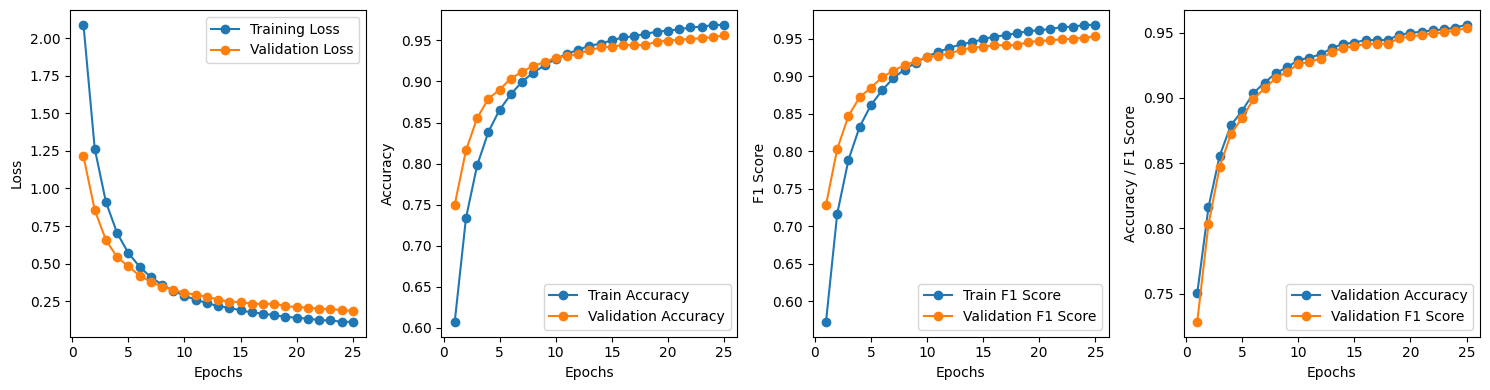

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Plot training and validation metrics
epochs = np.arange(1, num_epochs + 1)
plt.figure(figsize=(15, 4))
plt.subplot(1, 4, 1)
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(epochs, train_f1_scores, label='Train F1 Score', marker='o')
plt.plot(epochs, val_f1_scores, label='Validation F1 Score', marker='o')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.plot(epochs, val_f1_scores, label='Validation F1 Score', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / F1 Score')
plt.legend()

plt.tight_layout()
plt.show()